<a href="https://colab.research.google.com/github/joanby/tensorflow2/blob/master/Collab%2012%20-%20Crear%20una%20API%20para%20Clasificar%20Imágenes%20con%20TensorFlow%20Serving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Paso 1: Instalar las dependencias y configurar el proyecto en GPU


In [1]:
!pip install requests

## Paso 2: Importar las dependencias del proyecto

In [2]:
import os
import json
import random
import requests
import subprocess
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10

%matplotlib inline
tf.__version__

'2.4.0'

## Paso 3: Pre procesado de los datos

### Cargar el dataset

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 3s 0us/step


In [4]:
class_names = ['avión', 'coche', 'pájaro', 'gato', 'ciervo', 'perro', 'rana', 'caballo', 'barco', 'camión']

### Normalización de imágenes

In [5]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [6]:
X_train.shape

(50000, 32, 32, 3)

## Paso 4: Definir el modelo

NOTA: Vamos a usar el mismo modelo que creamos en la Sección de Redes Neuronales Convolucionales

In [7]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[32, 32, 3]))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

### Compilar el modelo

In [9]:
model.compile(optimizer='Adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'])

###  Entrenar el modelo

In [10]:
!nvidia-smi

Sun Jan 17 03:17:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    29W /  70W |    235MiB / 15079MiB |      1%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
model.fit(X_train, 
          y_train, 
          batch_size=128, 
          epochs=10)

Epoch 1/10
391/391 [==============================] - 11s 9ms/step - loss: 1.7595 - sparse_categorical_accuracy: 0.3541
Epoch 2/10
391/391 [==============================] - 4s 9ms/step - loss: 1.0916 - sparse_categorical_accuracy: 0.6132
Epoch 3/10
391/391 [==============================] - 4s 9ms/step - loss: 0.8768 - sparse_categorical_accuracy: 0.6949
Epoch 4/10
391/391 [==============================] - 4s 9ms/step - loss: 0.7454 - sparse_categorical_accuracy: 0.7389
Epoch 5/10
391/391 [==============================] - 4s 9ms/step - loss: 0.6335 - sparse_categorical_accuracy: 0.7791
Epoch 6/10
391/391 [==============================] - 4s 9ms/step - loss: 0.5495 - sparse_categorical_accuracy: 0.8120
Epoch 7/10
391/391 [==============================] - 4s 9ms/step - loss: 0.4691 - sparse_categorical_accuracy: 0.8368
Epoch 8/10
391/391 [==============================] - 4s 9ms/step - loss: 0.3889 - sparse_categorical_accuracy: 0.8666
Epoch 9/10
391/391 [===========================

### Evaluar el modelo

In [12]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.9086 - sparse_categorical_accuracy: 0.7468


In [13]:
print("La precisión del modelo es de {} %".format(test_accuracy*100.0))

La precisión del modelo es de 74.68000054359436 %


## Paso 5: Guardar el modelo para subir a producción

### Crear un directorio para el modelo

In [14]:
MODEL_DIR = "model/"
version = 1

In [15]:
export_path = os.path.join(MODEL_DIR, str(version))
export_path

'model/1'

In [16]:
if os.path.isdir(export_path):
    !rm -r {export_path}

### Guardar el modelo para TensorFlow Serving

In [17]:
#tf.saved_model.simple_save(tf.keras.backend.get_session(), export_dir=export_path, inputs={"input_image":model.input}, outputs={t.name:t for t in model.outputs})

In [18]:
model.save( export_path   )

INFO:tensorflow:Assets written to: model/1/assets


## Paso 6: Configurar el entorno de producción

### Exportar el MODEL_DIR a las variables de entorno

In [19]:
#crear nueva variable de entorno con la ruta absoluta de nuestro modelo
os.environ['MODEL_DIR'] = os.path.abspath(MODEL_DIR)

### Ejecutar la API REST de TensorFlow Serving

In [20]:
!apt-get remove tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package tensorflow-model-server


Agregue el URI de distribución de TensorFlow Serving como fuente de paquete (configuración única)

In [21]:
!echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  32700      0 --:--:-- --:--:-- --:--:-- 32700
OK


Instalar y actualizar TensorFlow ModelServer usando el gestor de paquetes apt-get de linux

In [22]:
!apt-get update && apt-get install tensorflow-model-server

Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:9 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server-universal amd64 Packages [346 B]
Get:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:11 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server

In [23]:

# ejecutar en segundo plano y que se sigua ejecutando el comando aunque cierre terminal o sesion
# por alguna razon el se tiene que ejecuta justo antes la celda de la instalacion de tensorflow serving
%%bash --bg
nohup tensorflow_model_server --rest_api_port=8000 --model_name=cifar10 --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [30]:
#como el proceso se ejecuta en segundo plano necesita server.log  para almacenar o mostrar lo que saldria por consola
!tail server.log

2021-01-17 03:18:51.775145: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:206] Restoring SavedModel bundle.
2021-01-17 03:18:51.777002: I external/org_tensorflow/tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz
2021-01-17 03:18:51.860267: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:190] Running initialization op on SavedModel bundle at path: /content/model/1
2021-01-17 03:18:51.868545: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:277] SavedModel load for tags { serve }; Status: success: OK. Took 174553 microseconds.
2021-01-17 03:18:51.869942: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /content/model/1/assets.extra/tf_serving_warmup_requests
2021-01-17 03:18:51.870101: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: cifar10 version: 1}
2021-01-17 03:18:51.871529: I tensorflow_serving/model_servers/

## Paso 7: Crear nuestra primera petición por POST

In [31]:
random_image = np.random.randint(0, len(X_test))
random_image

2558

### Crear el objeto de datos en JSON

In [32]:
#serialice objeto python(dict) a Json formateado a string 
data = json.dumps({"signature_name":"serving_default", "instances":[X_test[random_image].tolist()]})

In [33]:
print("tipo de dato: {}".format(type(data)))
data

tipo de dato: <class 'str'>


'{"signature_name": "serving_default", "instances": [[[[0.4823529411764706, 0.4980392156862745, 0.5058823529411764], [0.5490196078431373, 0.5725490196078431, 0.6196078431372549], [0.5529411764705883, 0.5686274509803921, 0.5764705882352941], [0.5568627450980392, 0.5647058823529412, 0.6039215686274509], [0.5411764705882353, 0.5686274509803921, 0.6509803921568628], [0.5647058823529412, 0.6, 0.6745098039215687], [0.5450980392156862, 0.5725490196078431, 0.592156862745098], [0.5725490196078431, 0.596078431372549, 0.6274509803921569], [0.5372549019607843, 0.5686274509803921, 0.5843137254901961], [0.6078431372549019, 0.6509803921568628, 0.6823529411764706], [0.6666666666666666, 0.7019607843137254, 0.7647058823529411], [0.6313725490196078, 0.6549019607843137, 0.7098039215686275], [0.5568627450980392, 0.596078431372549, 0.6509803921568628], [0.6274509803921569, 0.6627450980392157, 0.7450980392156863], [0.6235294117647059, 0.6392156862745098, 0.7019607843137254], [0.6431372549019608, 0.6588235294

### Enviar la primera petición POST al modelo

In [34]:
# los headers son usados para que Request haga conjeturas sobre la codificacion de la respuesta 
headers = {"content-type":"application/json"}

In [35]:
json_response = requests.post(url="http://localhost:8000/v1/models/cifar10:predict", data=data, headers=headers)

In [36]:
json_response

<Response [200]>

In [37]:
print(json_response.text)

{
    "predictions": [[4.3977383e-05, 7.86564851e-06, 0.0731058195, 0.00130355067, 0.450307608, 4.49132822e-05, 0.473905444, 0.00036650023, 3.5311823e-05, 0.000879034516]
    ]
}


In [38]:
#deserializar de un objeto json(string format) a uno python especificamene a un dict 
predictions = json.loads(json_response.text)["predictions"]

In [39]:
predictions

[[4.3977383e-05,
  7.86564851e-06,
  0.0731058195,
  0.00130355067,
  0.450307608,
  4.49132822e-05,
  0.473905444,
  0.00036650023,
  3.5311823e-05,
  0.000879034516]]

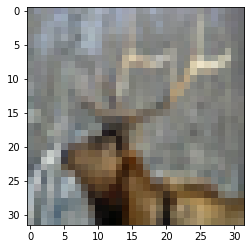

In [40]:
plt.imshow(X_test[random_image])

In [41]:
class_names[np.argmax(predictions[0])]

'rana'

## Paso 8: Enviar una petición POST a un modelo específico 

In [42]:
specific_json_response = requests.post(url="http://localhost:8000/v1/models/cifar10/versions/1:predict", data=data, headers=headers)

In [43]:
specific_json_response

<Response [200]>